In [15]:
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings("ignore")

In [2]:
con= sqlite3.connect("zomato_rawdata.sqlite")

In [9]:
df=pd.read_sql_query("select * from users",con)

In [10]:
df.head()

,index,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


## 1. Checking Missing Values

In [11]:
missing = df.isnull().sum()
print(missing[missing > 0])

rate                            7775
phone                           1208
location                          21
rest_type                        227
dish_liked                     28078
cuisines                          45
approx_cost(for two people)      346
dtype: int64


In [16]:
for column in df.columns:
    if df[column].isnull().sum() > 0:
        if df[column].dtype in ['float64', 'int64']:
           
            mean_val = df[column].mean()
            df[column].fillna(mean_val, inplace=True)
        else:
            
            mode_val = df[column].mode()[0]
            df[column].fillna(mode_val, inplace=True)

In [17]:
df.isnull().sum()

index                          0
url                            0
address                        0
name                           0
online_order                   0
book_table                     0
rate                           0
votes                          0
phone                          0
location                       0
rest_type                      0
dish_liked                     0
cuisines                       0
approx_cost(for two people)    0
reviews_list                   0
menu_item                      0
listed_in(type)                0
listed_in(city)                0
dtype: int64

##  2. Analyze Relationship Between Online Order and Rating

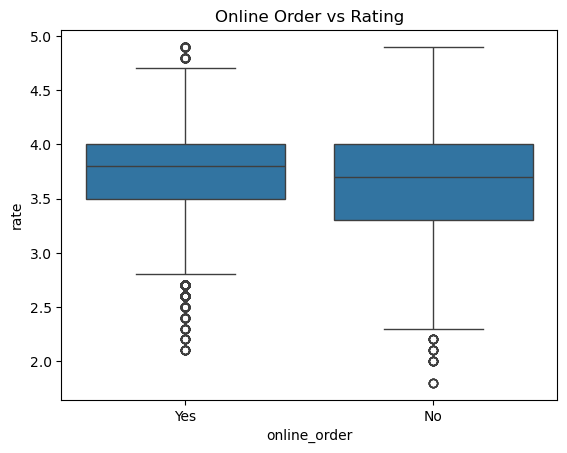

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Strip any non-numeric ratings and convert to float
df['rate'] = df['rate'].astype(str).str.replace('/5', '').replace('NEW', None).replace('-', None)
df['rate'] = pd.to_numeric(df['rate'], errors='coerce')

# Boxplot: Online order vs rating
sns.boxplot(x='online_order', y='rate', data=df)
plt.title('Online Order vs Rating')
plt.show()

In [20]:
# check correlation
print(df.groupby('online_order')['rate'].mean())

online_order
No     3.65907
Yes    3.72244
Name: rate, dtype: float64


## 3. Text Cleaning (e.g., for "reviews", "dish_liked", etc.)

In [32]:
text_columns = ['location', 'rest_type', 'dish_liked', 'cuisines', 'reviews_list']

def clean_text(text):
    if isinstance(text, str):
        text = text.strip()  # Remove leading/trailing whitespace
        text = text.lower()  # Convert to lowercase
        text = text.replace('\n', ' ').replace('\r', '')  # Remove line breaks
        text = ' '.join(text.split())  # Remove extra spaces
    return text

# Apply cleaning function to relevant columns   
df['clean_dish_liked'] = df['dish_liked'].apply(clean_text)

# Preview cleaned data
df[text_columns].head()


,location,rest_type,dish_liked,cuisines,reviews_list
0,banashankari,casual dining,"pasta, lunch buffet, masala papad, paneer laja...","north indian, mughlai, chinese","[('rated 4.0', 'rated\n a beautiful place to d..."
1,banashankari,casual dining,"momos, lunch buffet, chocolate nirvana, thai g...","chinese, north indian, thai","[('rated 4.0', 'rated\n had been here for dinn..."
2,banashankari,"cafe, casual dining","churros, cannelloni, minestrone soup, hot choc...","cafe, mexican, italian","[('rated 3.0', ""rated\n ambience is not that g..."
3,banashankari,quick bites,masala dosa,"south indian, north indian","[('rated 4.0', ""rated\n great food and proper ..."
4,basavanagudi,casual dining,"panipuri, gol gappe","north indian, rajasthani","[('rated 4.0', 'rated\n very good restaurant i..."


## 4. Unigram Analysis

In [36]:
from collections import Counter

# Combine all text
text = ' '.join(df['clean_dish_liked'])

# Count words
unigrams = text.split()
unigram_freq = Counter(unigrams)

# Convert to DataFrame for display
unigram_df = pd.DataFrame(unigram_freq.items(), columns=['word', 'count'])
unigram_df = unigram_df.sort_values(by='count', ascending=False).reset_index(drop=True)

# Top 20
print(unigram_df.head(20))


          word  count
0      biryani  29661
1      chicken  10845
2     biryani,   6058
3       pizza,   3945
4     chicken,   3927
5       pasta,   3415
6     burgers,   2747
7   cocktails,   2650
8       mutton   2458
9    chocolate   2384
10     coffee,   2349
11      butter   2289
12      paneer   2171
13      masala   2164
14        peri   2130
15       beer,   1702
16    paratha,   1676
17  mocktails,   1655
18       soup,   1615
19        tea,   1580


## 5. Bi-gram and Tri-gram Analysis

In [ ]:
from nltk import ngrams

# Choose the column for analysis
text_column = 'dish_liked' 

# Prepare and clean the text
text_data = df[text_column].dropna().str.lower()

# Join all text into a single string
all_text = ' '.join(text_data)

# Tokenize text (split into words)
tokens = all_text.split()

# Generate bigrams and trigrams
bigrams = list(ngrams(tokens, 2))
trigrams = list(ngrams(tokens, 3))

# Count frequency of each n-gram
bigram_counts = Counter(bigrams)
trigram_counts = Counter(trigrams)

# Convert to DataFrame and sort by frequency
bigram_df = pd.DataFrame(bigram_counts.items(), columns=['bigram', 'count']).sort_values(by='count', ascending=False)
trigram_df = pd.DataFrame(trigram_counts.items(), columns=['trigram', 'count']).sort_values(by='count', ascending=False)

# Display top 10 bigrams and trigrams
print("Top 10 Bigrams:")
print(bigram_df.head(10))

print("\nTop 10 Trigrams:")
print(trigram_df.head(10))

## 6. Spatial Analysis (Assuming you have latitude, longitude columns)

##### Restaurant Count by Location

In [43]:
#Spatial analysis typically refers to examining data based on location

location_counts = df['location'].value_counts().reset_index()
location_counts.columns = ['location', 'restaurant_count']
print(location_counts.head(10))

                location  restaurant_count
0                    btm              5145
1                    hsr              2523
2  koramangala 5th block              2504
3               jp nagar              2235
4             whitefield              2144
5            indiranagar              2083
6              jayanagar              1926
7           marathahalli              1846
8      bannerghatta road              1630
9              bellandur              1286


##### Average Rating by Location

In [44]:
# Convert rating to numeric
df['rate'] = pd.to_numeric(df['rate'], errors='coerce')

# Group by location and calculate mean rating
avg_rating_by_location = df.groupby('location')['rate'].mean().reset_index()
avg_rating_by_location = avg_rating_by_location.sort_values(by='rate', ascending=False)
print(avg_rating_by_location.head(10))

                 location      rate
51           lavelle road  4.142505
42  koramangala 3rd block  4.020419
81         st. marks road  4.017201
44  koramangala 5th block  4.005821
11          church street  3.992125
75            sankey road  3.965385
43  koramangala 4th block  3.918668
14        cunningham road  3.901053
69         residency road  3.863636
56                mg road  3.855857


##### Online Order Availability by Location

In [45]:
online_order_by_location = df.groupby(['location', 'online_order']).size().unstack().fillna(0)
online_order_by_location['total'] = online_order_by_location.sum(axis=1)
online_order_by_location['percent_online'] = (online_order_by_location['Yes'] / online_order_by_location['total']) * 100
online_order_by_location = online_order_by_location.sort_values(by='percent_online', ascending=False)

print(online_order_by_location[['Yes', 'No', 'percent_online']].head(10))

online_order                     Yes    No  percent_online
location                                                  
rajarajeshwari nagar             2.0   0.0      100.000000
kanakapura road                 17.0   2.0       89.473684
nagawara                       162.0  25.0       86.631016
kumaraswamy layout             165.0  30.0       84.615385
rammurthy nagar                 27.0   5.0       84.375000
yelahanka                        5.0   1.0       83.333333
varthur main road, whitefield   97.0  20.0       82.905983
kaggadasapura                   79.0  22.0       78.217822
yeshwantpur                     93.0  26.0       78.151261
kengeri                          7.0   2.0       77.777778
